# **Pendahuluan**


---

Phising Detected adalah proyek model machine learning untuk mengidentifikasi website phising. Phising merupakan suatu kejahatan yang cukup sering terjadi dimanapun. Salah satu penyebabnya adalah kurangnya pengetahuan dan kesadaran masyarakat dalam membedakan antara website resmi dan website phising. Oleh karena itu diperlukan suatu media yang dapat mengidentifikasi website phising untuk masyarakat. Salah satu media yang dapat digunakan adalah sebuah website phising detected yang dapat diakses melalui desktop maupun smartphone dan menurut kami ini adalah kesempatan yang baik untuk mengedukasi masyarakat melalui website ini karena mudah untuk diakses oleh siapapun

# **Data Understanding**
---
Data yang digunakan pada model ini adalah data web phishing dari kaggle.

kaggle datasets download -d taruntiwarihp/phishing-site-urlskaggle datasets

Url sumber data : [Dataset kaggle : Phishing Site Urls](https://www.kaggle.com/taruntiwarihp/phishing-site-urls)

### Import Library
---
Pada bagian ini kami mengimport semua library yang dibutuhkan pada pembuatan model prediksi.

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
import networkx as next
import pickle
import warnings
warnings.filterwarnings('ignore')

### Mempersiapkan Dataset
---
Pada bagian ini saya mendownload dataset langsung dari kaggle kemudian menampilkannya, dataset yang saya gunakan yaitu phishing_site_urls.csv

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"devisdestiannugraha","key":"bee36c4a86c43a4117f92345da40f1e2"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls  ~/.kaggle

kaggle.json


In [6]:
!kaggle datasets download -d taruntiwarihp/phishing-site-urls

  0% 0.00/9.03M [00:00<?, ?B/s]
100% 9.03M/9.03M [00:00<00:00, 80.5MB/s]


In [7]:
!unzip phishing-site-urls.zip

Archive:  phishing-site-urls.zip
  inflating: phishing_site_urls.csv  


In [10]:
df = pd.read_csv('/content/phishing_site_urls.csv')
df

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad


# **Exploratory Data Analysis**
---
tahap eksplorasi dilakukan untuk mendapatkan insight dari dataset

### Deskripsi Variabel
---
Pada dataset ini terdapat 2 variabel yaitu URL merepresentasikan alamat link dan Label merepresentasikan apakah link dikategorikan bad/good.

**Penjelasan** : `df.describe()` dan `df.info()` digunakan untuk mendapatkan informasi dataframe.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [12]:
df.describe()

,URL,Label
count,549346,549346
unique,507195,2
top,jhomitevd2abj3fk.onion.to/,good
freq,52,392924


### Visualisasi Data
---


untuk masalah klasifikasi kita melakukan pengecekan terlebih dahulu, apakah kelasnya seimbang atau tidak.

In [14]:
label_counts = pd.DataFrame(df.Label.value_counts())

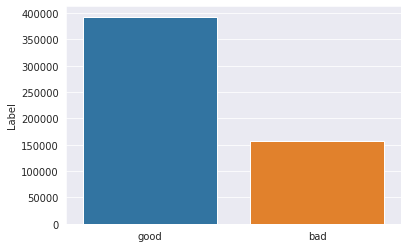

In [15]:
sns.set_style('darkgrid')
sns.barplot(label_counts.index,label_counts.Label)

# **Data Preparation**
---

### Menangani Missing Value
---

In [13]:
df.isnull().sum()

URL      0
Label    0
dtype: int64

setelah melakukan pengecekan missing value, tidak ada data yang hilang pada dataset yang digunakan.

### Tokenizer
---

membuat vektor URL menggunaka CountVectorizer dan mengumpulkan kata-kata dengan tokenizer.

In [16]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [17]:
df.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [18]:
tokenizer.tokenize(df.URL[0])

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [22]:
print('Mengumpulkan kata...')
t0= time.perf_counter()
df['text_tokenized'] = df.URL.map(lambda t: tokenizer.tokenize(t)) # doing with all rows
t1 = time.perf_counter() - t0
print('Waktu yang dibutuhkan',t1 ,'detik')

Mengumpulkan kata...
Waktu yang dibutuhkan 3.301518582999961 detik


In [23]:
df.sample(10)

,URL,Label,text_tokenized
394618,musicsonglyrics.com/still-would-stand-all-time...,good,"[musicsonglyrics, com, still, would, stand, al..."
21173,mobile.paypal.com.fundacionmoya.org.ar/webscrc...,bad,"[mobile, paypal, com, fundacionmoya, org, ar, ..."
222272,norwood.dadeschools.net/staff.html,good,"[norwood, dadeschools, net, staff, html]"
547088,www.draaksteken.nl/76733c,bad,"[www, draaksteken, nl, c]"
537016,phaseiv.org/b0uo1,bad,"[phaseiv, org, b, uo]"
319538,edinburgpolitics.com/2008/03/14/hidalgo-county...,good,"[edinburgpolitics, com, hidalgo, county, road,..."
148554,beerbrands.blogspot.com/2009/11/pepito-sangria...,good,"[beerbrands, blogspot, com, pepito, sangria, h..."
399875,myspace.com/looseboots1977,good,"[myspace, com, looseboots]"
361531,independent.co.uk/news/obituaries/richard-hick...,good,"[independent, co, uk, news, obituaries, richar..."
34943,besdess.net/S7XIde/webscr_prim.php?YmVzZGVzcy5...,bad,"[besdess, net, S, XIde, webscr, prim, php, YmV..."


In [24]:
stemmer = SnowballStemmer("english")

In [25]:
print('Mengumpulkan kata...')
t0= time.perf_counter()
df['text_stemmed'] = df['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Waktu yang dibutuhkan',t1 ,'detik')

Mengumpulkan kata...
Waktu yang dibutuhkan 62.30379906799999 detik


In [26]:
df.sample(10)

,URL,Label,text_tokenized,text_stemmed
57332,www3.lu.se/klass/textiles/,good,"[www, lu, se, klass, textiles]","[www, lu, se, klass, textil]"
216564,mp3bear.com/?q=david+usher,good,"[mp, bear, com, q, david, usher]","[mp, bear, com, q, david, usher]"
467168,wta.org/go-hiking/hikes/green-to-cedar-river-t...,good,"[wta, org, go, hiking, hikes, green, to, cedar...","[wta, org, go, hike, hike, green, to, cedar, r..."
72097,www.xellsoft.com/TurboLocator.html,good,"[www, xellsoft, com, TurboLocator, html]","[www, xellsoft, com, turboloc, html]"
194455,goodfishbadfish.com.au/,good,"[goodfishbadfish, com, au]","[goodfishbadfish, com, au]"
20368,painterspaintings.com/P_mindelse-koordinaterne...,bad,"[painterspaintings, com, P, mindelse, koordina...","[painterspaint, com, p, mindels, koordinatern,..."
127182,boinobrecarnes.com.br/wp-admin/user/,bad,"[boinobrecarnes, com, br, wp, admin, user]","[boinobrecarn, com, br, wp, admin, user]"
43175,tinyurl.com/bvk2k3e,bad,"[tinyurl, com, bvk, k, e]","[tinyurl, com, bvk, k, e]"
527319,illuminatework.ru/Install.apk,bad,"[illuminatework, ru, Install, apk]","[illuminatework, ru, instal, apk]"
298693,canadiansoccernews.com/content.php?123-voyageu...,good,"[canadiansoccernews, com, content, php, voyage...","[canadiansoccernew, com, content, php, voyageu..."


In [27]:
print('Mengumpulkan kata...')
t0= time.perf_counter()
df['text_sent'] = df['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Waktu yang dibutuhkan',t1 ,'detik')

Mengumpulkan kata...
Waktu yang dibutuhkan 0.5008008719998998 detik


In [28]:
df.sample(10)

,URL,Label,text_tokenized,text_stemmed,text_sent
108879,opelzielonagora.pl/logs/bofa/f997116cc1d3a4eb6...,bad,"[opelzielonagora, pl, logs, bofa, f, cc, d, a,...","[opelzielonagora, pl, log, bofa, f, cc, d, a, ...",opelzielonagora pl log bofa f cc d a eb d a fe e
366643,judgebillharris.com/supporters/,good,"[judgebillharris, com, supporters]","[judgebillharri, com, support]",judgebillharri com support
377663,linkedin.com/pub/robert-picard/10/a54/566,good,"[linkedin, com, pub, robert, picard, a]","[linkedin, com, pub, robert, picard, a]",linkedin com pub robert picard a
479957,zona-musical.com/postt194024.html,good,"[zona, musical, com, postt, html]","[zona, music, com, postt, html]",zona music com postt html
177818,en.wikipedia.org/wiki/Ma_Foi_Randstad,good,"[en, wikipedia, org, wiki, Ma, Foi, Randstad]","[en, wikipedia, org, wiki, ma, foi, randstad]",en wikipedia org wiki ma foi randstad
349681,handicapperspicks.com/denver-broncos-vs-jackso...,good,"[handicapperspicks, com, denver, broncos, vs, ...","[handicapperspick, com, denver, bronco, vs, ja...",handicapperspick com denver bronco vs jacksonv...
531259,www.nieli.de/9u8jreve,bad,"[www, nieli, de, u, jreve]","[www, nieli, de, u, jreve]",www nieli de u jreve
245974,the-artists.org/artist/Arthur-Lismer,good,"[the, artists, org, artist, Arthur, Lismer]","[the, artist, org, artist, arthur, lismer]",the artist org artist arthur lismer
176550,en.wikipedia.org/wiki/Jonathan_Beaulieu-Bourgault,good,"[en, wikipedia, org, wiki, Jonathan, Beaulieu,...","[en, wikipedia, org, wiki, jonathan, beaulieu,...",en wikipedia org wiki jonathan beaulieu bourgault
512468,renklerle.com/vycrub,bad,"[renklerle, com, vycrub]","[renklerl, com, vycrub]",renklerl com vycrub


In [29]:
bad_sites = df[df.Label == 'bad']
good_sites = df[df.Label == 'good']

In [30]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [31]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


In [32]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

In [33]:
data = good_sites.text_sent
data.reset_index(drop=True, inplace=True)

In [34]:
data = bad_sites.text_sent
data.reset_index(drop=True, inplace=True)

# **Modelling**
---
Pada tahap ini saya mengembangkan model dengan menggunakan algoritma `logistic regression` dan `Multinomial Naive Bayes`.

In [39]:
cv = CountVectorizer()

In [41]:
feature = cv.fit_transform(df.text_sent)

In [42]:
feature[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [44]:
trainX, testX, trainY, testY = train_test_split(feature, df.Label)

In [45]:
lr = LogisticRegression()
lr.fit(trainX,trainY)

LogisticRegression()

In [46]:
lr.score(testX,testY)

0.9643577477300364

In [47]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

In [48]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

Training Accuracy : 0.9784616355467963
Testing Accuracy : 0.9643577477300364


In [49]:
print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))


CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36961
        Good       0.99      0.96      0.98    100376

    accuracy                           0.96    137337
   macro avg       0.95      0.96      0.96    137337
weighted avg       0.97      0.96      0.96    137337




CONFUSION MATRIX


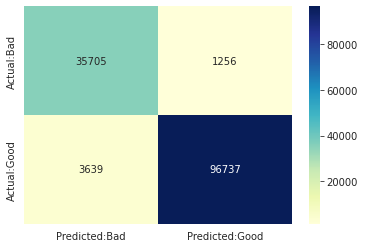

In [50]:
print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [52]:
mnb = MultinomialNB()
mnb.fit(trainX,trainY)

MultinomialNB()

In [53]:
mnb.score(testX,testY)

0.9581467485091417

In [54]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

In [55]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

Training Accuracy : 0.9738695028506659
Testing Accuracy : 0.9581467485091417


In [56]:
print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))


CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.92      0.94      0.93     38480
        Good       0.98      0.97      0.97     98857

    accuracy                           0.96    137337
   macro avg       0.95      0.95      0.95    137337
weighted avg       0.96      0.96      0.96    137337




CONFUSION MATRIX


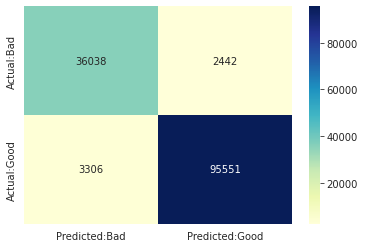

In [57]:
print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

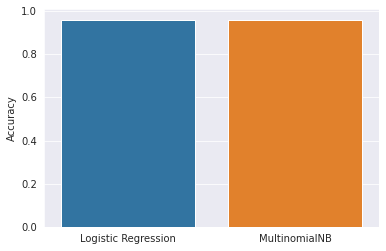

In [58]:
acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
sns.set_style('darkgrid')
sns.barplot(acc.index,acc.Accuracy)

In [60]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())

In [62]:
trainX, testX, trainY, testY = train_test_split(df.URL, df.Label)

In [63]:
pipeline_ls.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)),
                ('logisticregression', LogisticRegression())])

In [64]:
pipeline_ls.score(testX,testY) 

0.9663892468890394

In [65]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

Training Accuracy : 0.9804785817785534
Testing Accuracy : 0.9663892468890394


In [66]:
print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))


CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36805
        Good       0.99      0.97      0.98    100532

    accuracy                           0.97    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.97      0.97    137337




CONFUSION MATRIX


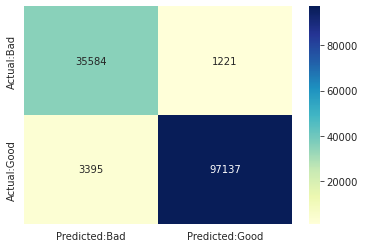

In [67]:
print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [69]:
pickle.dump(pipeline_ls,open('web_phishing.pkl','wb'))

In [71]:
loaded_model = pickle.load(open('web_phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9663892468890394


In [72]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('phishing.pkl', 'rb'))

result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)

['bad' 'bad' 'bad' 'bad']
******************************
['good' 'good' 'good' 'good']
